#Домашнее задание 

In [65]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm import tqdm
import os
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import random as rd
%matplotlib inline

In [66]:
device = torch.device('cuda:0')

In [67]:
!wget http://sereja.me/f/universum_compressed.tar
!tar xf universum_compressed.tar

--2022-03-19 08:24:22--  http://sereja.me/f/universum_compressed.tar
Resolving sereja.me (sereja.me)... 213.159.215.132
Connecting to sereja.me (sereja.me)|213.159.215.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72028160 (69M) [application/x-tar]
Saving to: ‘universum_compressed.tar.1’

universum_compresse 100%[===================>]  68.69M  8.37MB/s    in 15s     

2022-03-19 08:24:38 (4.51 MB/s) - ‘universum_compressed.tar.1’ saved [72028160/72028160]



#1. Колоризация изображений

###Обработка данных

In [68]:
class ColorizationDataset(Dataset):
    def __init__(self, path, transform_x, transform_y):
        self.transform_x = transform_x
        self.transform_y = transform_y
      
        filenames = []
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('.jpg') or file.endswith('.JPG'):
                    filenames.append(os.path.join(root, file))

        self.images = []
        for filename in tqdm(filenames):
            try:
                with Image.open(filename) as image:
                    self.images.append(image.copy())
            except:
                pass
                #print('Could not load image:', filename)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        Y = self.transform_y(img)
        X = self.transform_x(Y)
        return X, Y

In [69]:
transform_all = transforms.Compose([
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

def to_grayscale(x):
    return 1 - (x[0] * 0.299 + x[1] * 0.587 + x[2] * 0.114).view(1, 128, 128)

In [70]:
dataset = ColorizationDataset('universum-photos', to_grayscale, transform_all)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

100%|██████████| 1254/1254 [00:01<00:00, 756.12it/s]


###Модель

In [71]:
def Block(channels_in, channels_out):
    return nn.Sequential(
        nn.Conv2d(channels_in, channels_out, (3, 3), padding=1),
        nn.ReLU(),
    )

def FullBlock(channels_in, channels_out):
    return nn.Sequential(
        nn.Conv2d(channels_in, channels_out, (3, 3), padding=1),
        nn.ReLU(),
        nn.MaxPool2d((2, 2), stride=(2, 2)), 
        nn.BatchNorm2d(channels_out),
    )

In [72]:
class Colorizer(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.preconcat = nn.Sequential(
            FullBlock(1, 16),
            FullBlock(16, 32),
            FullBlock(32, 64),
            
            Block(64, 128),
            nn.BatchNorm2d(128),
            Block(128, 256),
            nn.BatchNorm2d(256),
            Block(256, 256),
            nn.BatchNorm2d(256),
            Block(256, 256),
            nn.BatchNorm2d(256),

            nn.Upsample(scale_factor=2),
            Block(256, 256),
            nn.Upsample(scale_factor=2),
            Block(256, 128),
            nn.Upsample(scale_factor=2),
            Block(128, 64)           
        )
         
        self.postconcat = nn.Sequential(         
            nn.Conv2d(65, 32, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, (3, 3), padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        h = self.preconcat(x)
        h = torch.cat((h, x), 1)
        h = self.postconcat(h)
        return h

###Отображение картинок

In [73]:
def to_numpy_image(img):
    # tl;dr: PyTorch хочет (3, 128, 128), а plt.imshow хочет (128, 128, 3)
    # есть два популярных формата для цветных картинок:
    #  1. где размерность, соответствующая каналам, идёт последней
    #  2. где размерность, соответствующая каналам, идёт первой
    # при работе с нейросетями удобен первый подход -- так запрашиваемая
    # при вычислениях память идёт последовательно, и из-за кэширования
    # операции свёртки работают быстрее
    # второй подход удобнее при уже работе с устройством, которое эти картинки показывает
    # -- удобно на три лампочки послать сразу три последовательно идущих байта
    return img.detach().cpu().view(3, 128, 128).transpose(0, 1).transpose(1, 2).numpy()

In [74]:
def draw_picture(index_picture=None):
    if index_picture is None: 
      index_picture = rd.randint(0, len(dataset) - 1)
    img_gray, img_true = dataset[index_picture]
    img_pred = model(img_gray.to(device).view(1, 1, 128, 128))
    img_pred = to_numpy_image(img_pred)
    plt.figure(figsize=(10,10))
    
    plt.subplot(141)
    plt.axis('off')
    plt.set_cmap('Greys')
    plt.imshow(img_gray.reshape((128, 128)))

    plt.subplot(142)
    plt.axis('off')
    plt.imshow(img_pred.reshape((128, 128, 3)))

    plt.subplot(143)
    plt.axis('off')
    plt.imshow(to_numpy_image(img_true))

    plt.show()
    

###Обучение модели

In [75]:
num_epochs = 50
lr = 1e-3

model = Colorizer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.L1Loss() 

EPOCH = 0, loss = 0.114


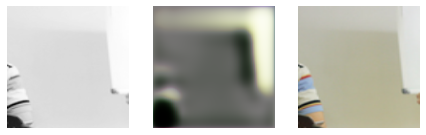

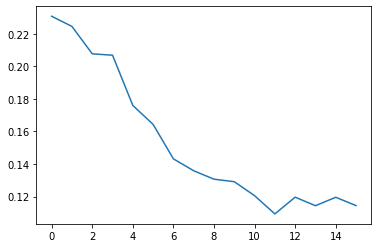

EPOCH = 1, loss = 0.102
EPOCH = 2, loss = 0.09
EPOCH = 3, loss = 0.085
EPOCH = 4, loss = 0.077
EPOCH = 5, loss = 0.084


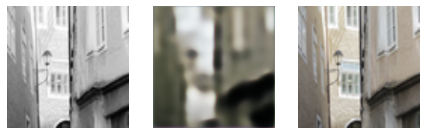

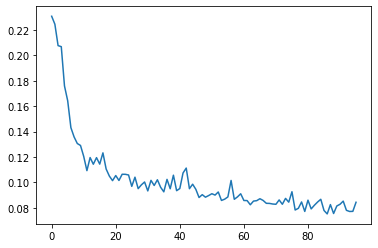

EPOCH = 6, loss = 0.078
EPOCH = 7, loss = 0.071
EPOCH = 8, loss = 0.072
EPOCH = 9, loss = 0.066
EPOCH = 10, loss = 0.088


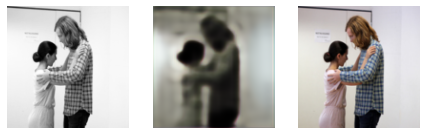

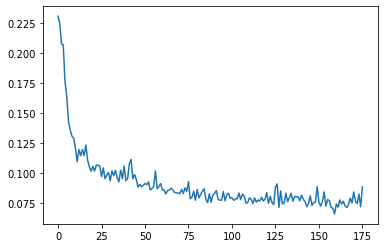

EPOCH = 11, loss = 0.071
EPOCH = 12, loss = 0.067
EPOCH = 13, loss = 0.081
EPOCH = 14, loss = 0.064
EPOCH = 15, loss = 0.072


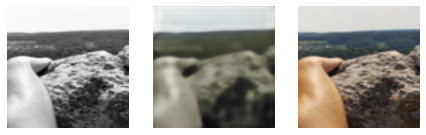

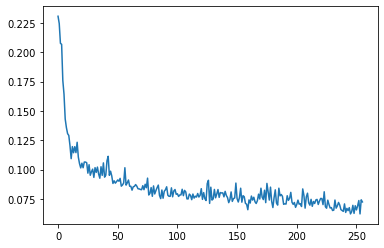

EPOCH = 16, loss = 0.07
EPOCH = 17, loss = 0.063
EPOCH = 18, loss = 0.069
EPOCH = 19, loss = 0.061
EPOCH = 20, loss = 0.073


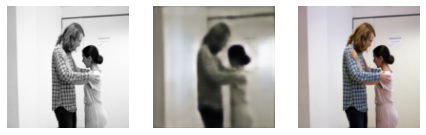

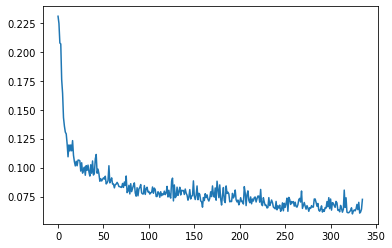

EPOCH = 21, loss = 0.068
EPOCH = 22, loss = 0.071
EPOCH = 23, loss = 0.071
EPOCH = 24, loss = 0.06
EPOCH = 25, loss = 0.06


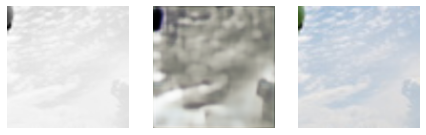

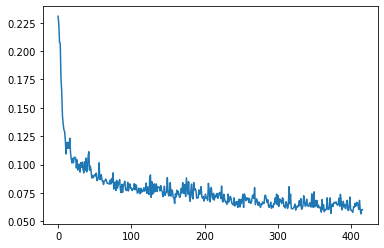

EPOCH = 26, loss = 0.059
EPOCH = 27, loss = 0.065
EPOCH = 28, loss = 0.055
EPOCH = 29, loss = 0.063
EPOCH = 30, loss = 0.057


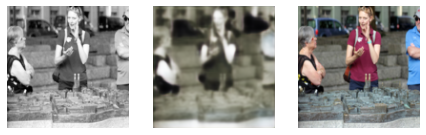

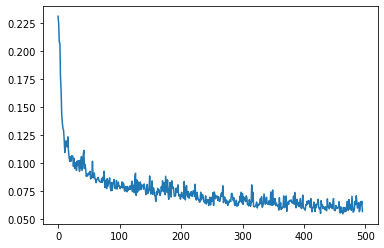

EPOCH = 31, loss = 0.061
EPOCH = 32, loss = 0.055
EPOCH = 33, loss = 0.053
EPOCH = 34, loss = 0.058
EPOCH = 35, loss = 0.057


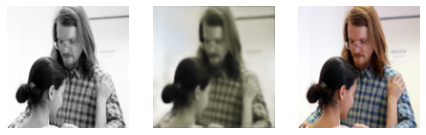

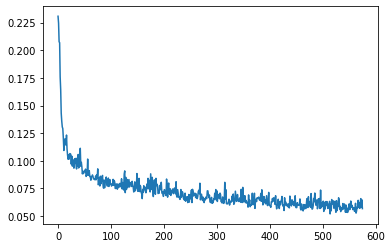

EPOCH = 36, loss = 0.06
EPOCH = 37, loss = 0.07
EPOCH = 38, loss = 0.059
EPOCH = 39, loss = 0.056
EPOCH = 40, loss = 0.056


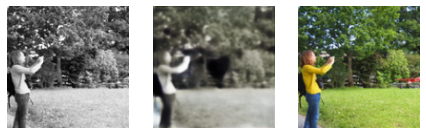

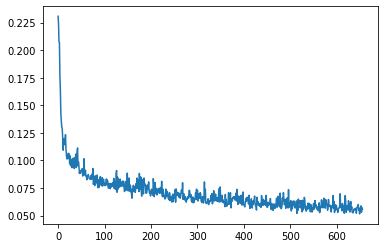

EPOCH = 41, loss = 0.058
EPOCH = 42, loss = 0.054
EPOCH = 43, loss = 0.053
EPOCH = 44, loss = 0.056
EPOCH = 45, loss = 0.049


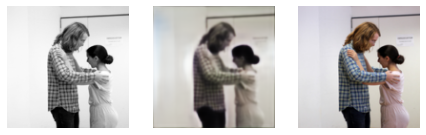

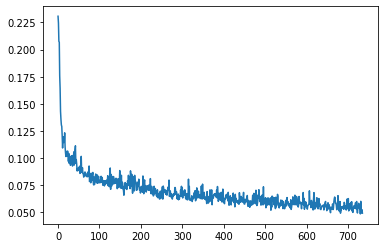

EPOCH = 46, loss = 0.048
EPOCH = 47, loss = 0.053
EPOCH = 48, loss = 0.054
EPOCH = 49, loss = 0.045


In [76]:
history = []
for epoch in range(num_epochs):
    for x, y in loader:
      # 0. распакавать данные на нужное устройство
      x = x.to(device)
      y = y.to(device)

      # 1. сбросить градиент
      optimizer.zero_grad()

      # 2. прогнать данные через сеть
      colorized = model(x)

      # 3. посчитать loss
      loss = criterion(colorized, y)

      # 4. залоггировать его куда-нибудь
      history.append(loss.item())

      # 5. сделать .backward()  
      loss.backward()

      # 6. optimizer.step()
      optimizer.step()

    print(f"EPOCH = {epoch}, loss = {round(history[-1], 3)}")
    if epoch % 5 == 0:
      draw_picture()
      plt.plot(history)
      plt.show()

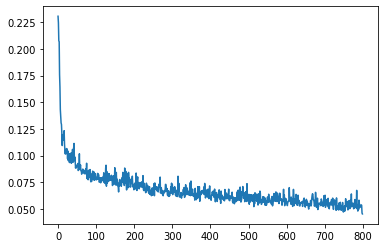

In [77]:
plt.plot(history)
plt.show()

###Итог

1


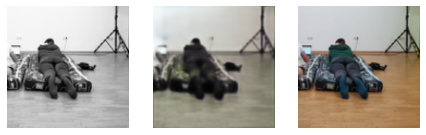

5


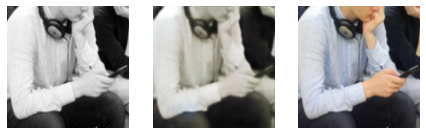

50


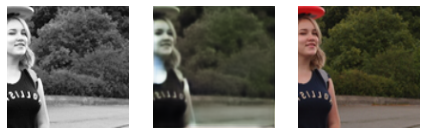

37


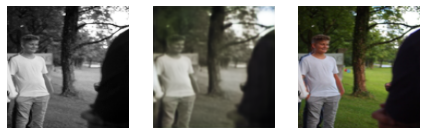

60


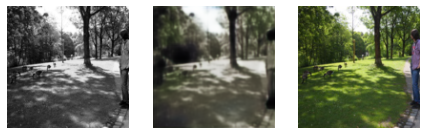

74


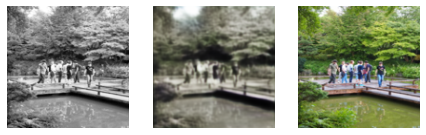

93


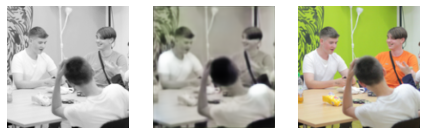

29


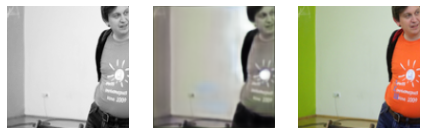

404


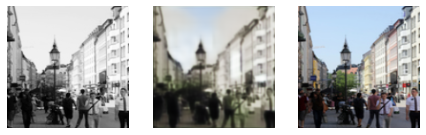

504


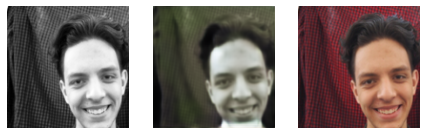

In [78]:
for index in (1, 5, 50, 37, 60, 74, 93, 29, 404, 504):
  print(index)
  draw_picture(index)